In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
from tsnecuda import TSNE
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor, as_completed

def load_single_embedding(args):
    emb_path, file = args
    return np.load(os.path.join(emb_path, file))

def load_embeddings(emb_path: str, file_list: list, meta_df: pd.DataFrame, num_workers: int=4):
    '''
    Load embeddings from a list of files in parallel.

    Args:
        emb_path (str): Path to the embeddings directory.
        file_list (list): List of files to load. Each file should be a .npy file.
        meta_df (pd.DataFrame): Metadata DataFrame. Columns should include 'file' and 'label'.
        num_workers (int): Number of workers to use for parallel processing.
    Returns:
        emb (np.array): Array of embeddings.
        labels (np.array): Array of labels.
    '''
    def load_file(file: str):
        file_path = os.path.join(emb_path, file)
        embedding = np.load(file_path)
        file_ = file.split('.')[0]
        label = meta_df.loc[meta_df['hash'] == file_, 'modification'].values[0]
        return embedding, label

    embeddings = []
    labels = []

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(load_file, file): file for file in file_list}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading embeddings"):
            emb, label = future.result()
            if emb is not None and label is not None:
                embeddings.append(emb)
                labels.append(label)

    return np.array(embeddings), np.array(labels)

def load_embeddings_v2(emb_path: str, file_list: list, meta_df: pd.DataFrame, query: str = None, num_workers: int = 4):
    '''
    Load embeddings from a list of files in parallel with optional filtering by query.

    Args:
        emb_path (str): Path to the embeddings directory.
        file_list (list): List of files to load. Each file should be a .npy file.
        meta_df (pd.DataFrame): Metadata DataFrame. Columns should include 'file' and 'label'.
        query (str, optional): Query string to filter metadata. Example: "modification='BASELINE'" or "snr>20".
        num_workers (int): Number of workers to use for parallel processing.
    Returns:
        emb (np.array): Array of embeddings.
        labels (np.array): Array of labels.
    '''
    # Filter metadata based on query condition if provided
    if query is not None:
        filtered_meta_df = meta_df.query(query)
        # Filter file_list to only include files from the filtered metadata
        filtered_hashes = set(filtered_meta_df['hash'].values)
        filtered_file_list = [file for file in file_list if file.split('.')[0] in filtered_hashes]
    else:
        filtered_file_list = file_list
        filtered_meta_df = meta_df
    
    print(f"Loading {len(filtered_file_list)} files after filtering.")
    
    def load_file(file: str):
        try:
            file_path = os.path.join(emb_path, file)
            embedding = np.load(file_path)
            file_hash = file.split('.')[0]
            label_row = filtered_meta_df.loc[filtered_meta_df['hash'] == file_hash]
            
            if label_row.empty:
                return None, None
                
            label = label_row['modification'].values[0]
            return embedding, label
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
            return None, None

    embeddings = []
    labels = []

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(load_file, file): file for file in filtered_file_list}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading embeddings"):
            emb, label = future.result()
            if emb is not None and label is not None:
                embeddings.append(emb)
                labels.append(label)

    return np.array(embeddings), np.array(labels)
# Perform t-SNE
def perform_tsne(embeddings):
    print(f"Original embedding shape: {embeddings.shape}")
    
    # Take the mean of each embedding if it's 3D
    if len(embeddings.shape) == 3:
        # Flatten the embeddings to 2D, keep the first dimension
        # For example, if the shape is (1000, 10, 256), it will be reshaped to (1000, 2560)
        embeddings = embeddings.reshape(embeddings.shape[0], -1)
        print(f"Reshaped embedding shape: {embeddings.shape}")
    
    # Standardize the features
    # scaler = StandardScaler()
    # embeddings_scaled = scaler.fit_transform(embeddings)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_seed=42, device=2)
    tsne_results = tsne.fit_transform(embeddings)
    print(f"t-SNE results shape: {tsne_results.shape}")
    
    return tsne_results

# Plot t-SNE results
def plot_tsne(tsne_results, labels, title="t-SNE Visualization of Embeddings", figsize=(12, 8)):
    print(f"t-SNE results shape: {tsne_results.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Unique labels: {np.unique(labels)}")
    
    plt.figure(figsize=figsize)
    
    # Create scatter plot
    unique_labels = np.unique(labels)
    colors = sns.color_palette("husl", n_colors=len(unique_labels))
    
    for label, color in zip(unique_labels, colors):
        mask = labels == label
        plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1], 
                   c=[color], label=label, alpha=0.6)
    
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    
    return plt


# MLAAD

In [4]:
mlaad_df = pd.read_csv('/nvme1/hungdx/Lightning-hydra/data/shortcutASV/mlaad/data.csv', sep='|')

In [5]:
# Load embeddings
emb_path = "/nvme1/hungdx/Lightning-hydra/logs/eval/cnsl_noisy/emb/mlaad"

file_list = os.listdir(emb_path)

embeddings, labels = load_embeddings_v2(emb_path, file_list, mlaad_df, query="target=='spoof'")



Loading 3600 files after filtering.


Loading embeddings: 100%|██████████| 3600/3600 [00:07<00:00, 501.20it/s]


In [10]:
print("embedding shape: ", embeddings.shape)


embedding shape:  (3600, 144)


In [6]:
mlaad_df['modification'].unique()

array(['BASELINE', 'BIT_DEPTH', 'MP3_COMPRESSION', 'ADD_BACKGROUND_NOISE',
       'ADD_BACKGROUND_MUSIC', 'EQUALIZATION', 'FREQ_MINUS', 'FREQ_PLUS',
       'GAUSSIAN_NOISE', 'SILENCE_INJECTION', 'HIGH_PASS_FILTER',
       'LOW_PASS_FILTER', 'TIME_STRETCH', 'PITCH_SHIFT', 'ECHO',
       'AMPLITUDE_MODULATION', 'AUTOTUNE', 'REVERB'], dtype=object)

In [13]:
labels

array(['BASELINE', 'BASELINE', 'BASELINE', ..., 'REVERB', 'REVERB',
       'REVERB'], shape=(7200,), dtype='<U20')

Processing embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Creating scatter plot: 100%|██████████| 18/18 [00:00<00:00, 529.46it/s]


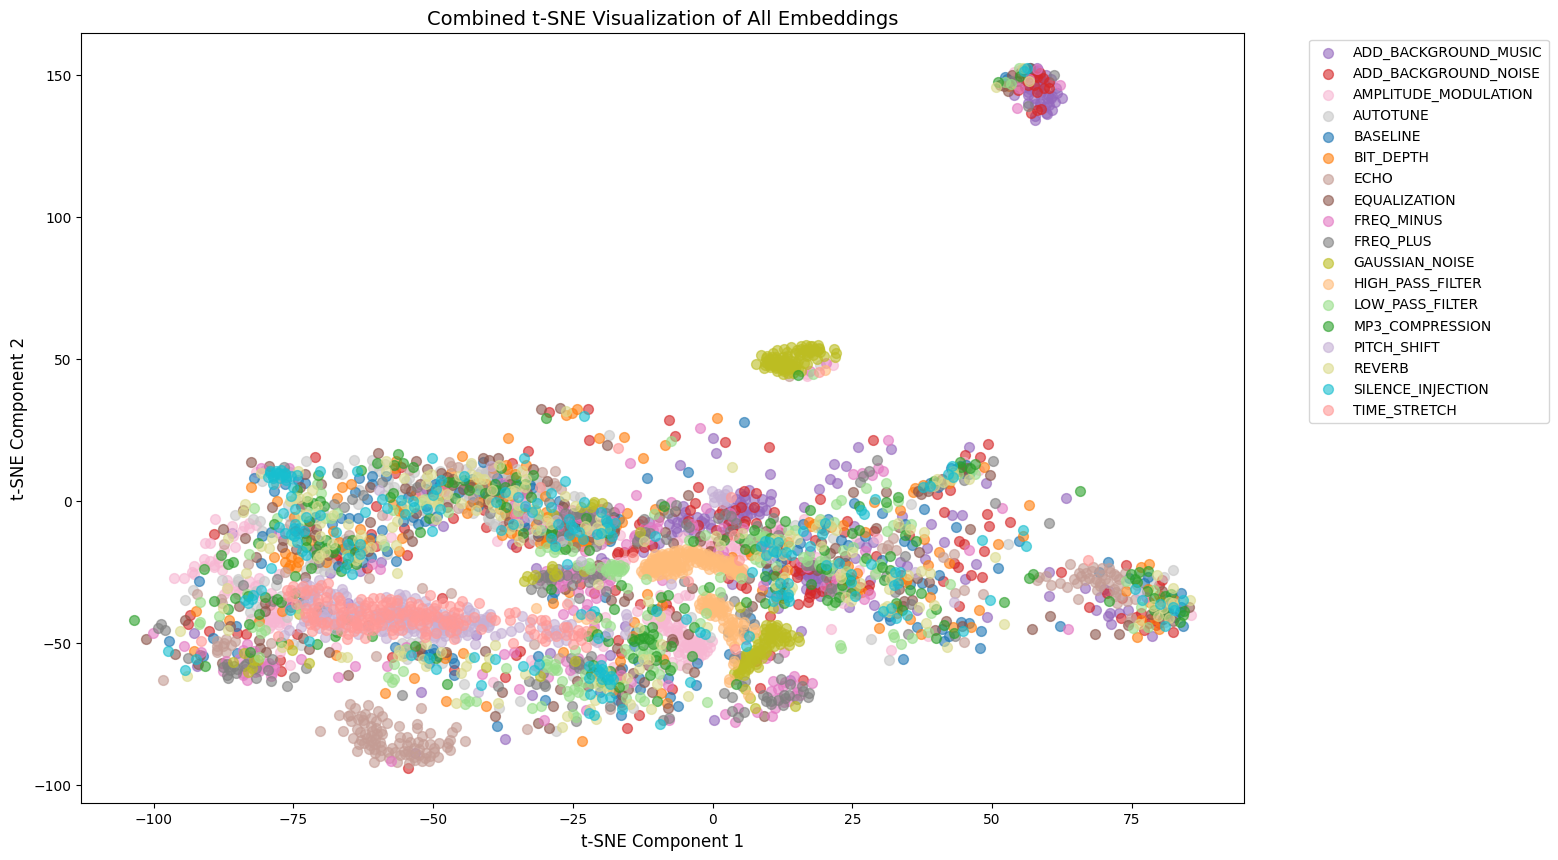

<Figure size 640x480 with 0 Axes>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tsnecuda import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
np.random.seed(42)

def visualize_embeddings_single(embeddings_list, labels_list, names_list):
    """
    Visualize multiple embeddings using t-SNE in a single figure with modified labels.
    
    Args:
        embeddings_list: List of embedding arrays
        labels_list: List of corresponding labels
        names_list: List of names for each embedding
    """
    # Set up the figure
    plt.figure(figsize=(15, 10))
    
    # Color palette - different colors for each view and class
    colors = {
    'BASELINE': '#1f77b4',  # Blue
    'BIT_DEPTH': '#ff7f0e',  # Orange
    'MP3_COMPRESSION': '#2ca02c',  # Green
    'ADD_BACKGROUND_NOISE': '#d62728',  # Red
    'ADD_BACKGROUND_MUSIC': '#9467bd',  # Purple
    'EQUALIZATION': '#8c564b',  # Brown
    'FREQ_MINUS': '#e377c2',  # Pink
    'FREQ_PLUS': '#7f7f7f',  # Gray
    'GAUSSIAN_NOISE': '#bcbd22',  # Olive
    'SILENCE_INJECTION': '#17becf',  # Cyan
    'HIGH_PASS_FILTER': '#ffbb78',  # Light Orange
    'LOW_PASS_FILTER': '#98df8a',  # Light Green
    'TIME_STRETCH': '#ff9896',  # Light Red
    'PITCH_SHIFT': '#c5b0d5',  # Light Purple
    'ECHO': '#c49c94',  # Light Brown
    'AMPLITUDE_MODULATION': '#f7b6d2',  # Light Pink
    'AUTOTUNE': '#c7c7c7',  # Light Gray
    'REVERB': '#dbdb8d'  # Light Olive
    }

    
    # Initialize lists to store all t-SNE results
    all_tsne = []
    all_labels = []
    
    # Process each embedding
    for idx, (embeddings, labels, name) in enumerate(tqdm(zip(embeddings_list, labels_list, names_list) , total=len(embeddings_list), desc="Processing embeddings")):
        # Standardize the embeddings
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(embeddings)
        
        # Apply t-SNE
        tsne = TSNE(
            n_components=2,
            random_seed=42,
  
        )
        embeddings_tsne = tsne.fit_transform(embeddings)
        
        # Store results with modified labels
        all_tsne.append(embeddings_tsne)
        modified_labels = np.array([f'{label}' for label in labels])
        all_labels.append(modified_labels)
    
    # Combine all results
    combined_tsne = np.vstack(all_tsne)
    combined_labels = np.concatenate(all_labels)
    
    #print(combined_labels)
    
    # Create scatter plot
    for label in tqdm(np.unique(combined_labels), desc="Creating scatter plot"):
        mask = combined_labels == label
        plt.scatter(
            combined_tsne[mask, 0],
            combined_tsne[mask, 1],
            c=[colors[label]],
            label=label,
            alpha=0.6,
            s=50
        )
    
    plt.title('Combined t-SNE Visualization of All Embeddings', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    
    return plt.gcf()

# Prepare the data
embeddings_list = [embeddings]
labels_list = [labels]
names_list = ['BASELINE', 'BIT_DEPTH', 'MP3_COMPRESSION', 'ADD_BACKGROUND_NOISE',
       'ADD_BACKGROUND_MUSIC', 'EQUALIZATION', 'FREQ_MINUS', 'FREQ_PLUS',
       'GAUSSIAN_NOISE', 'SILENCE_INJECTION', 'HIGH_PASS_FILTER',
       'LOW_PASS_FILTER', 'TIME_STRETCH', 'PITCH_SHIFT', 'ECHO',
       'AMPLITUDE_MODULATION', 'AUTOTUNE', 'REVERB']

# Create the visualization
fig = visualize_embeddings_single(embeddings_list, labels_list, names_list)

# Save the figure
plt.show()
plt.savefig('embeddings_tsne_xlsr_conformertcm_clean_mlaad_spoof.png', dpi=300, bbox_inches='tight')
# plt.close()

## Cluster

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
import umap

def cluster_and_visualize(embeddings, labels, n_clusters=None, method='kmeans', dim_reduction='tsne'):
    """
    Cluster embeddings and visualize the results.
    
    Args:
        embeddings (np.array): Array of embeddings with shape (n_samples, n_features)
        labels (np.array): Array of true labels
        n_clusters (int): Number of clusters for KMeans (default is None, which will use len(unique(labels)))
        method (str): Clustering method ('kmeans' or 'dbscan')
        dim_reduction (str): Dimensionality reduction method ('pca', 'tsne', or 'umap')
    """
    # Set up the figure
    plt.figure(figsize=(20, 15))
    
    # Standardize the embeddings
    print("Standardizing data...")
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)
    
    # Define colors for original labels
    unique_labels = np.unique(labels)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
    label_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}
    
    # Automatically set number of clusters if not provided
    if n_clusters is None:
        n_clusters = len(unique_labels)
    
    # Apply clustering
    print(f"Applying {method} clustering with {n_clusters} clusters...")
    if method == 'kmeans':
        clustering = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = clustering.fit_predict(embeddings_scaled)
    elif method == 'dbscan':
        # DBSCAN doesn't need n_clusters, it determines automatically based on eps and min_samples
        clustering = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)
        cluster_labels = clustering.fit_predict(embeddings_scaled)
        # Handle noise points (labeled as -1) for better visualization
        n_clusters = len(np.unique(cluster_labels[cluster_labels >= 0]))
        print(f"DBSCAN found {n_clusters} clusters and {np.sum(cluster_labels == -1)} noise points")
    else:
        raise ValueError(f"Unknown clustering method: {method}")
    
    # Apply dimensionality reduction
    print(f"Applying {dim_reduction} for visualization...")
    if dim_reduction == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        embeddings_2d = reducer.fit_transform(embeddings_scaled)
        explained_variance = reducer.explained_variance_ratio_.sum()
        print(f"Explained variance with PCA: {explained_variance:.2%}")
    elif dim_reduction == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_jobs=-1)
        embeddings_2d = reducer.fit_transform(embeddings_scaled)
    elif dim_reduction == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=42)
        embeddings_2d = reducer.fit_transform(embeddings_scaled)
    else:
        raise ValueError(f"Unknown dimensionality reduction method: {dim_reduction}")
    
    # Create a dataframe for easier plotting
    result_df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'true_label': labels,
        'cluster': cluster_labels
    })
    
    # Create the plots (2x2 grid: original labels, clusters, combined view 1, combined view 2)
    plt.subplot(2, 2, 1)
    for label in unique_labels:
        mask = result_df['true_label'] == label
        plt.scatter(
            result_df.loc[mask, 'x'],
            result_df.loc[mask, 'y'],
            c=[label_color_map[label]],
            label=label,
            alpha=0.7,
            s=50,
            edgecolors='w',
            linewidths=0.5
        )
    plt.title(f'Original Labels - {dim_reduction.upper()}', fontsize=14)
    plt.xlabel(f'{dim_reduction.upper()} Component 1', fontsize=12)
    plt.ylabel(f'{dim_reduction.upper()} Component 2', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(alpha=0.3)
    
    # Cluster plot
    plt.subplot(2, 2, 2)
    unique_clusters = np.unique(cluster_labels)
    for cluster_id in unique_clusters:  # Use unique cluster IDs instead of range
        mask = result_df['cluster'] == cluster_id
        if cluster_id == -1:
            # Plot noise points in black
            plt.scatter(
                result_df.loc[mask, 'x'],
                result_df.loc[mask, 'y'],
                c='black',
                label='Noise',
                alpha=0.5,
                s=30,
                marker='x'
            )
        else:
            plt.scatter(
                result_df.loc[mask, 'x'],
                result_df.loc[mask, 'y'],
                label=f'Cluster {cluster_id}',
                alpha=0.7,
                s=50,
                edgecolors='w',
                linewidths=0.5
            )
    plt.title(f'Clusters ({method.upper()}) - {dim_reduction.upper()}', fontsize=14)
    plt.xlabel(f'{dim_reduction.upper()} Component 1', fontsize=12)
    plt.ylabel(f'{dim_reduction.upper()} Component 2', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(alpha=0.3)
    
    # Cluster purity visualization
    plt.subplot(2, 2, 3)
    # Create a scatter plot where points are colored by true label but shaped by cluster
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', '|', '_']
    for i, label in enumerate(unique_labels):
        for j, cluster_id in enumerate(unique_clusters):  # Use unique cluster IDs
            mask = (result_df['true_label'] == label) & (result_df['cluster'] == cluster_id)
            if mask.sum() > 0:
                marker_idx = j % len(markers)
                marker = markers[marker_idx] if cluster_id >= 0 else 'x'
                plt.scatter(
                    result_df.loc[mask, 'x'],
                    result_df.loc[mask, 'y'],
                    c=[label_color_map[label]],
                    marker=marker,
                    alpha=0.7,
                    s=50,
                    edgecolors='w',
                    linewidths=0.5,
                    label=f'{label} - C{cluster_id}' if cluster_id >= 0 else f'{label} - Noise'
                )
    plt.title(f'Label Distribution in Clusters - {dim_reduction.upper()}', fontsize=14)
    plt.xlabel(f'{dim_reduction.upper()} Component 1', fontsize=12)
    plt.ylabel(f'{dim_reduction.upper()} Component 2', fontsize=12)
    # Use a compact legend with small font
    handles, labels_legend = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels_legend, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), 
               loc='upper left', fontsize=6)
    plt.grid(alpha=0.3)
    
    # Cluster composition analysis
    plt.subplot(2, 2, 4)
    
    # Get the actual unique clusters that exist in the data
    unique_clusters = np.unique(cluster_labels)
    n_unique_clusters = len(unique_clusters)
    
    # Create a matrix showing the distribution of true labels within each cluster
    # Use the actual number of unique clusters found
    cluster_label_matrix = np.zeros((len(unique_labels), n_unique_clusters))
    
    # Create a mapping from cluster_id to matrix column index
    cluster_to_col = {cluster_id: i for i, cluster_id in enumerate(unique_clusters)}
    
    for i, label in enumerate(unique_labels):
        for cluster_id in unique_clusters:
            mask = (result_df['true_label'] == label) & (result_df['cluster'] == cluster_id)
            # Use the mapping to get the correct column index
            j = cluster_to_col[cluster_id]
            cluster_label_matrix[i, j] = mask.sum()
    
    # Normalize by cluster size
    cluster_sums = cluster_label_matrix.sum(axis=0, keepdims=True)
    # Avoid division by zero
    cluster_sums[cluster_sums == 0] = 1
    cluster_label_matrix = cluster_label_matrix / cluster_sums
    
    # Plot the heatmap
    cluster_ids = [f'C{cluster_id}' for cluster_id in unique_clusters]
    if -1 in unique_clusters:
        noise_idx = np.where(unique_clusters == -1)[0][0]
        cluster_ids[noise_idx] = 'Noise'
        
    sns.heatmap(cluster_label_matrix, annot=True, fmt='.2f', cmap='YlGnBu',
                xticklabels=cluster_ids, yticklabels=unique_labels)
    plt.title('Cluster Composition Analysis', fontsize=14)
    plt.xlabel('Cluster ID', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    plt.tight_layout()
    
    # Calculate and print cluster quality metrics
    print("\nCluster quality metrics:")
    
    # Calculate purity for each cluster
    cluster_purities = []
    for cluster_id in unique_clusters:
        cluster_mask = result_df['cluster'] == cluster_id
        if cluster_mask.sum() > 0:
            cluster_data = result_df.loc[cluster_mask]
            most_common_label = cluster_data['true_label'].value_counts().idxmax()
            purity = (cluster_data['true_label'] == most_common_label).mean()
            dominant_label_count = (cluster_data['true_label'] == most_common_label).sum()
            print(f"Cluster {cluster_id}: {cluster_mask.sum()} samples, dominant label: {most_common_label} "
                  f"({dominant_label_count} samples, {purity:.2%} purity)")
            cluster_purities.append(purity)
    
    if cluster_purities:
        print(f"Average cluster purity: {np.mean(cluster_purities):.2%}")
    
    return plt.gcf(), result_df

# Example usage
def analyze_embeddings(embeddings, labels, n_clusters=None):
    """
    Perform multiple clustering and visualization analyses on the embeddings.
    
    Args:
        embeddings (np.array): Array of embeddings with shape (n_samples, n_features)
        labels (np.array): Array of true labels
        n_clusters (int): Number of clusters (default: None, will use number of unique labels)
    """
    # Try KMeans with t-SNE visualization
    fig1, df1 = cluster_and_visualize(
        embeddings, labels, n_clusters=n_clusters, 
        method='kmeans', dim_reduction='tsne'
    )
    plt.savefig('kmeans_tsne_clustering.png', dpi=300, bbox_inches='tight')
    
    # Try KMeans with UMAP visualization
    fig2, df2 = cluster_and_visualize(
        embeddings, labels, n_clusters=n_clusters, 
        method='kmeans', dim_reduction='umap'
    )
    plt.savefig('kmeans_umap_clustering.png', dpi=300, bbox_inches='tight')
    
    # Try DBSCAN with t-SNE visualization
    fig3, df3 = cluster_and_visualize(
        embeddings, labels, 
        method='dbscan', dim_reduction='tsne'
    )
    plt.savefig('dbscan_tsne_clustering.png', dpi=300, bbox_inches='tight')
    
    return {
        'kmeans_tsne': (fig1, df1),
        'kmeans_umap': (fig2, df2),
        'dbscan_tsne': (fig3, df3)
    }

# Example of how to call the function (uncomment to use)
# results = analyze_embeddings(embeddings, labels)  # Use the same number of clusters as labels
# results = analyze_embeddings(embeddings, labels, n_clusters=10)  # Use 10 clusters

Standardizing data...
Applying kmeans clustering with 18 clusters...
Applying tsne for visualization...


/tmp/ipykernel_575999/1307649210.py:141: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
/tmp/ipykernel_575999/1307649210.py:141: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
/tmp/ipykernel_575999/1307649210.py:141: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
/tmp/ipykernel_575999/1307649210.py:141: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
/tmp/ipykernel_57599


Cluster quality metrics:
Cluster 0: 326 samples, dominant label: AMPLITUDE_MODULATION (57 samples, 17.48% purity)
Cluster 1: 118 samples, dominant label: PITCH_SHIFT (61 samples, 51.69% purity)
Cluster 2: 78 samples, dominant label: HIGH_PASS_FILTER (71 samples, 91.03% purity)
Cluster 3: 933 samples, dominant label: EQUALIZATION (136 samples, 14.58% purity)
Cluster 4: 216 samples, dominant label: BIT_DEPTH (45 samples, 20.83% purity)
Cluster 5: 52 samples, dominant label: HIGH_PASS_FILTER (36 samples, 69.23% purity)
Cluster 6: 117 samples, dominant label: ECHO (87 samples, 74.36% purity)
Cluster 7: 203 samples, dominant label: TIME_STRETCH (103 samples, 50.74% purity)
Cluster 8: 429 samples, dominant label: BIT_DEPTH (54 samples, 12.59% purity)
Cluster 9: 82 samples, dominant label: ADD_BACKGROUND_MUSIC (43 samples, 52.44% purity)
Cluster 10: 139 samples, dominant label: ECHO (60 samples, 43.17% purity)
Cluster 11: 92 samples, dominant label: FREQ_PLUS (26 samples, 28.26% purity)
Clus

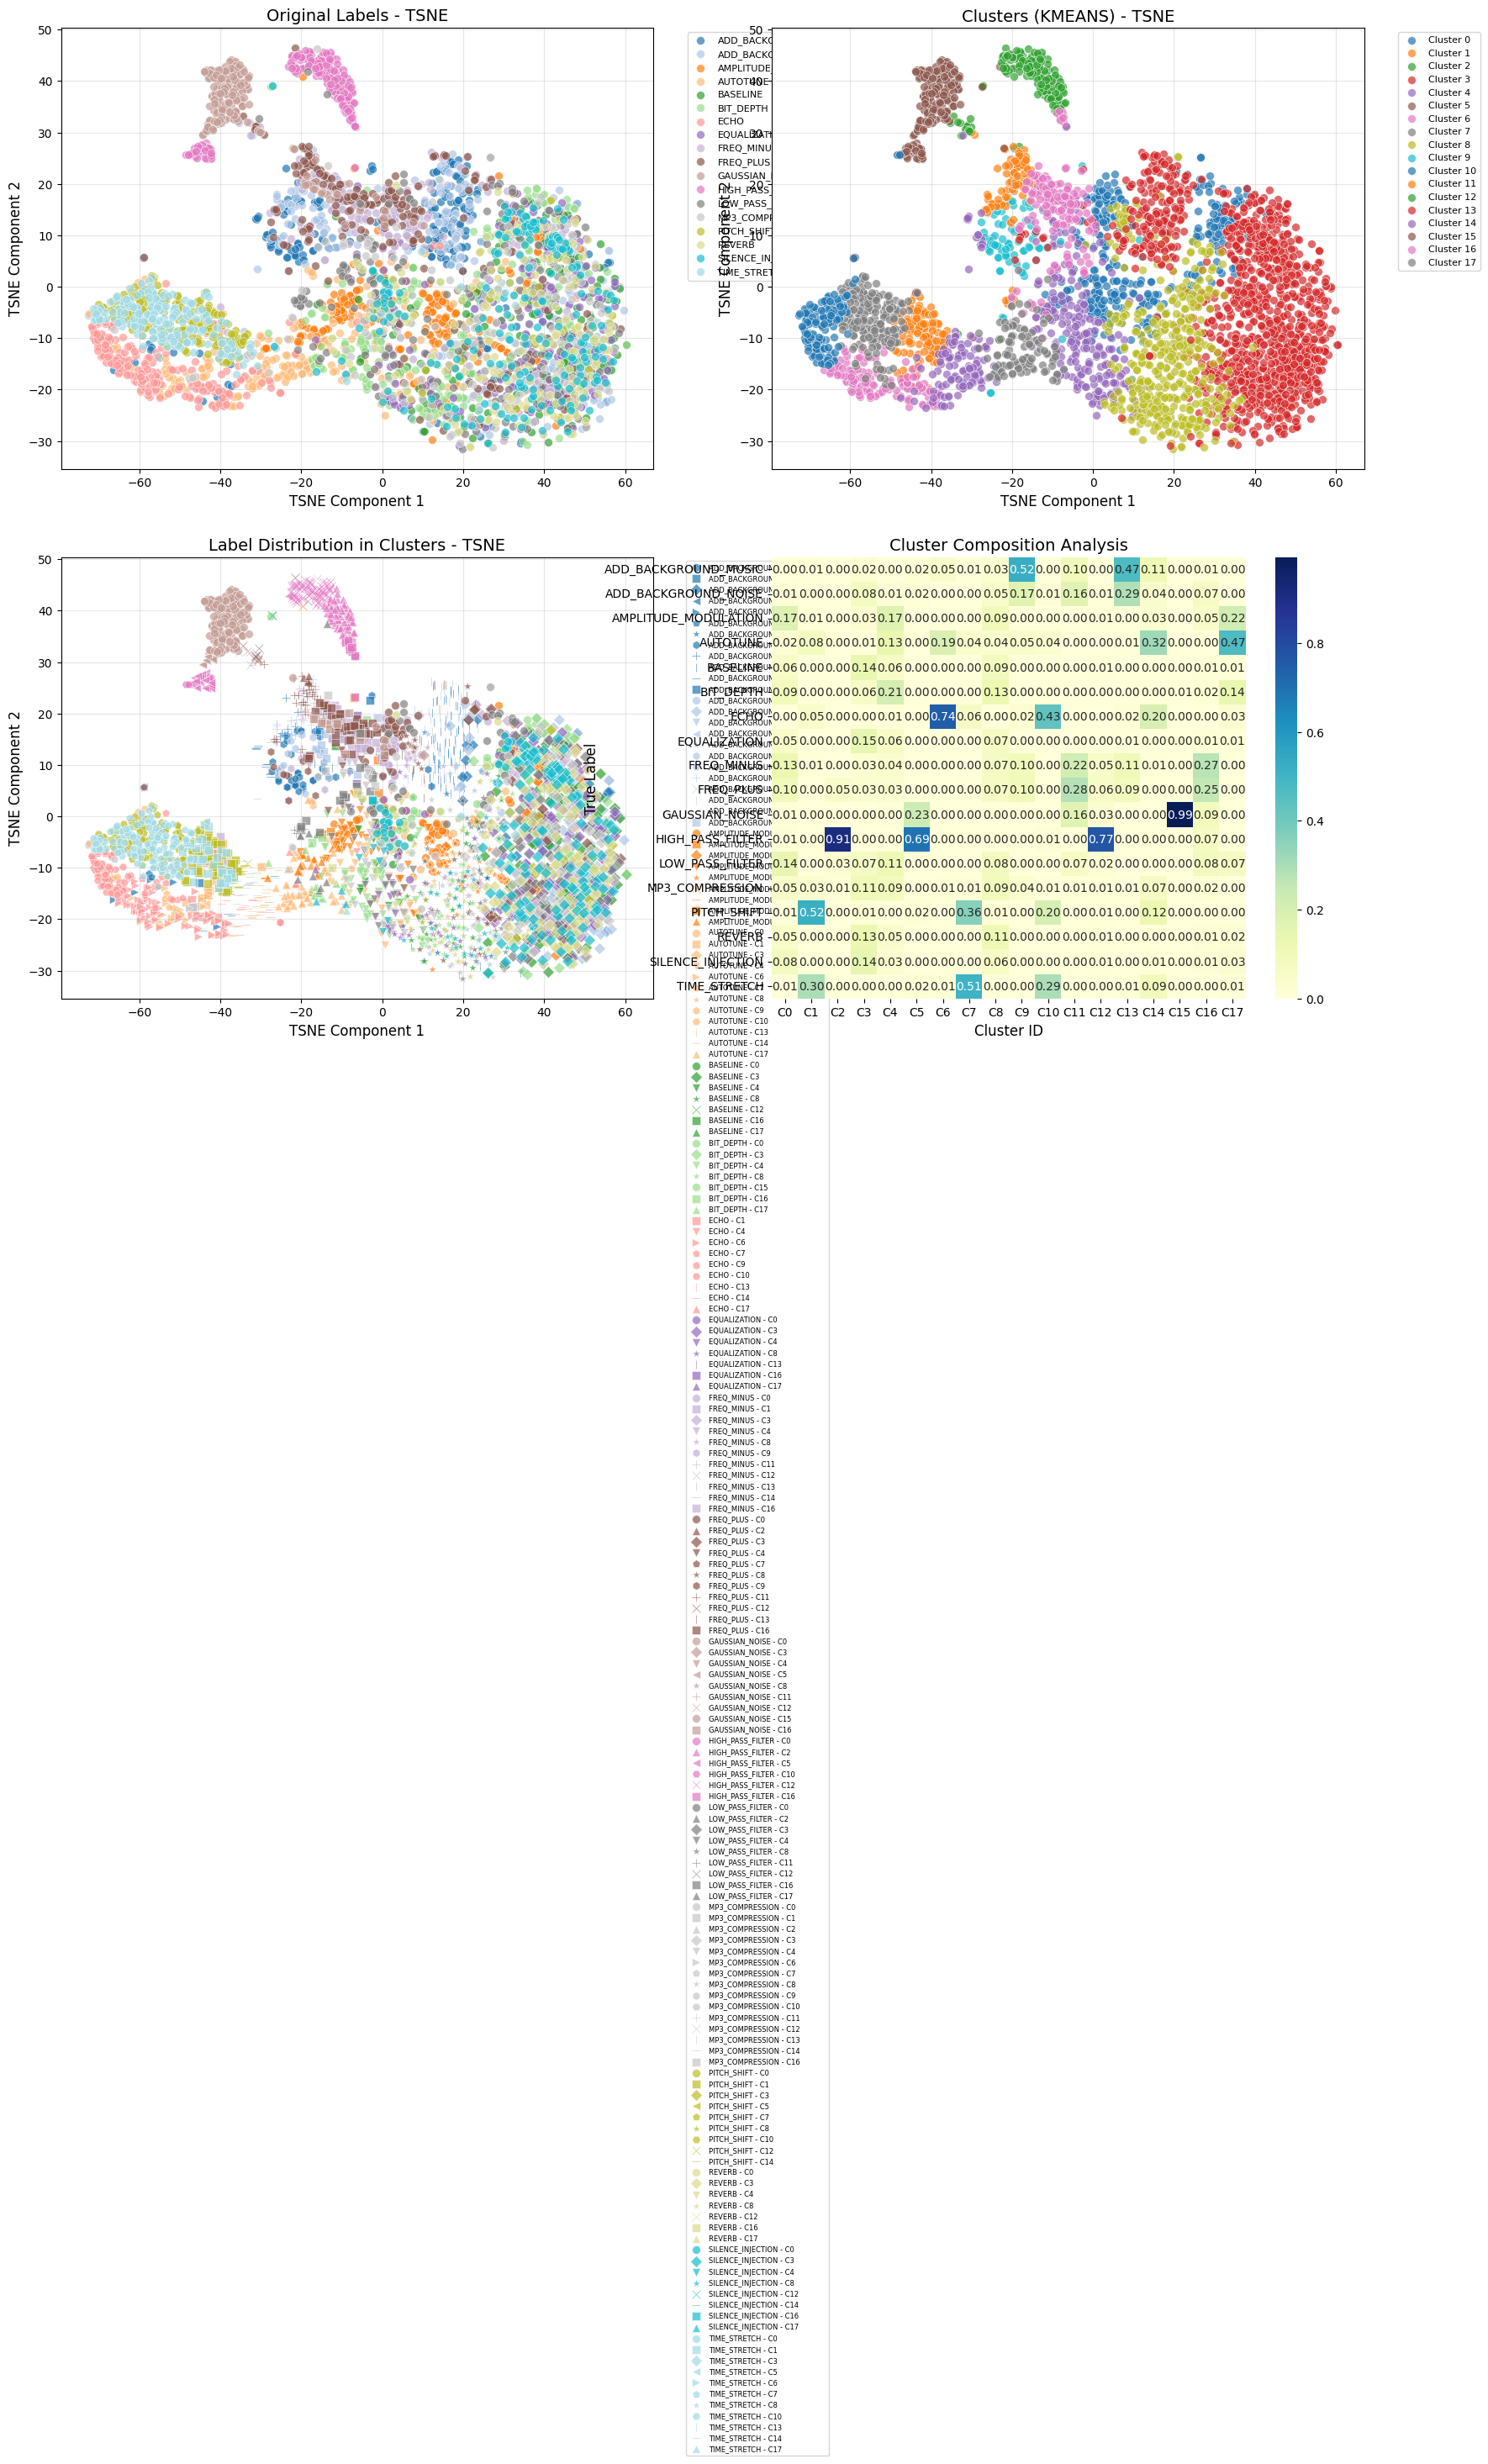

In [46]:
# For a simpler approach, just use KMeans with t-SNE
fig, df = cluster_and_visualize(
    embeddings, 
    labels, 
    method='kmeans', 
    dim_reduction='tsne'
)
plt.savefig('kmeans_tsne_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

# ASV19




In [7]:
asv19df = pd.read_csv('/nvme1/hungdx/Lightning-hydra/data/shortcutASV/asv19/data.csv', sep='|')


In [8]:
# Load embeddings
emb_path = "/nvme1/hungdx/Lightning-hydra/logs/eval/cnsl_noisy/emb/asv19"

file_list = os.listdir(emb_path)

embeddings, labels = load_embeddings_v2(emb_path, file_list, mlaad_df, query="target=='spoof'")


Loading 556 files after filtering.


Loading embeddings: 100%|██████████| 556/556 [00:01<00:00, 530.83it/s]


Creating scatter plot: 100%|██████████| 10/10 [00:00<00:00, 516.06it/s]


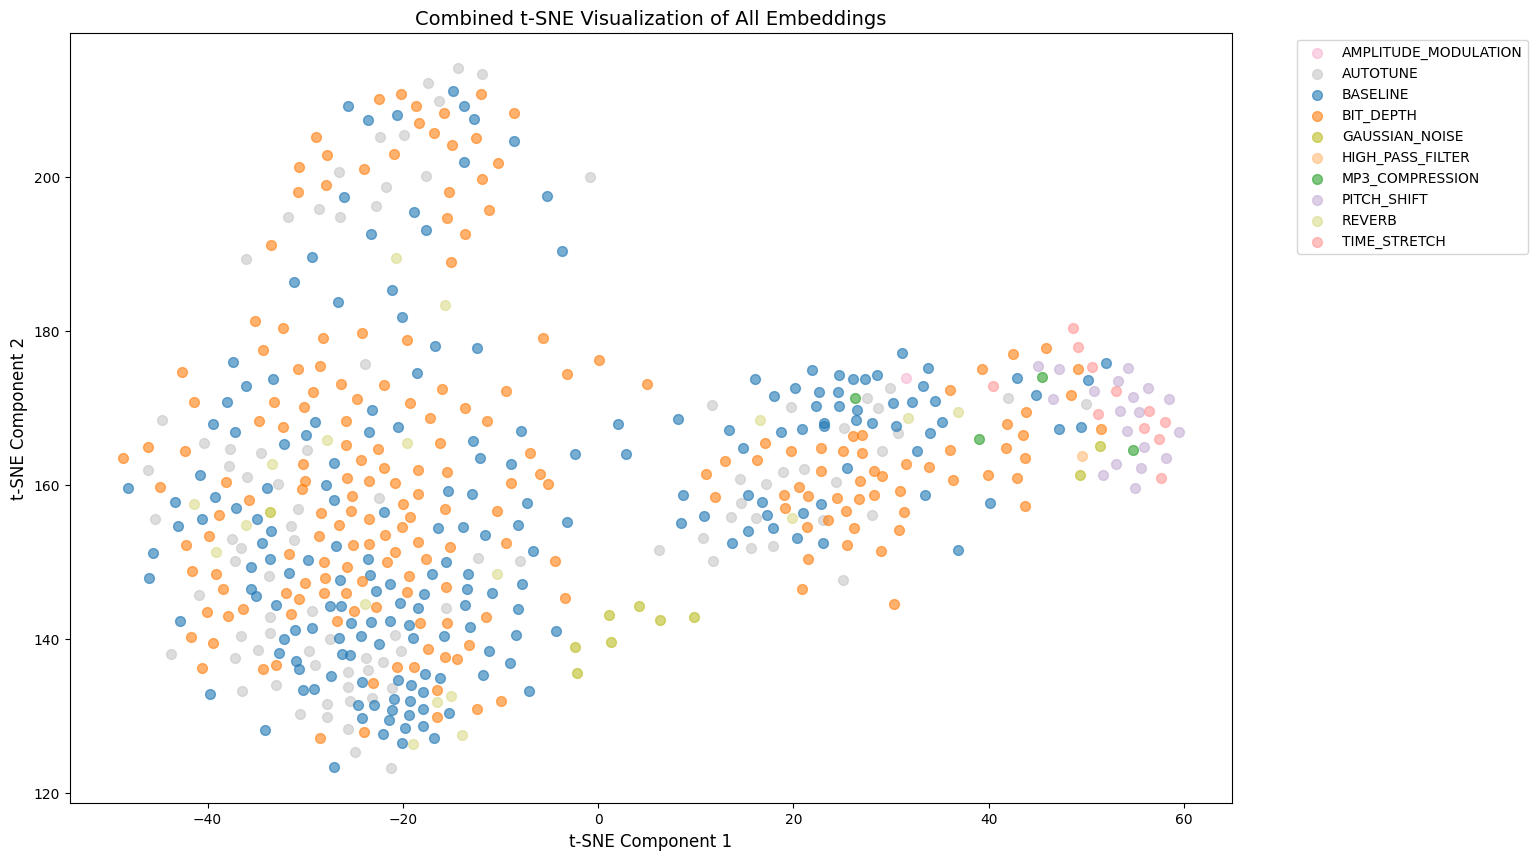

<Figure size 640x480 with 0 Axes>

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tsnecuda import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
np.random.seed(42)

def visualize_embeddings_single(embeddings_list, labels_list, names_list):
    """
    Visualize multiple embeddings using t-SNE in a single figure with modified labels.
    
    Args:
        embeddings_list: List of embedding arrays
        labels_list: List of corresponding labels
        names_list: List of names for each embedding
    """
    # Set up the figure
    plt.figure(figsize=(15, 10))
    
    # Color palette - different colors for each view and class
    colors = {
    'BASELINE': '#1f77b4',  # Blue
    'BIT_DEPTH': '#ff7f0e',  # Orange
    'MP3_COMPRESSION': '#2ca02c',  # Green
    'ADD_BACKGROUND_NOISE': '#d62728',  # Red
    'ADD_BACKGROUND_MUSIC': '#9467bd',  # Purple
    'EQUALIZATION': '#8c564b',  # Brown
    'FREQ_MINUS': '#e377c2',  # Pink
    'FREQ_PLUS': '#7f7f7f',  # Gray
    'GAUSSIAN_NOISE': '#bcbd22',  # Olive
    'SILENCE_INJECTION': '#17becf',  # Cyan
    'HIGH_PASS_FILTER': '#ffbb78',  # Light Orange
    'LOW_PASS_FILTER': '#98df8a',  # Light Green
    'TIME_STRETCH': '#ff9896',  # Light Red
    'PITCH_SHIFT': '#c5b0d5',  # Light Purple
    'ECHO': '#c49c94',  # Light Brown
    'AMPLITUDE_MODULATION': '#f7b6d2',  # Light Pink
    'AUTOTUNE': '#c7c7c7',  # Light Gray
    'REVERB': '#dbdb8d'  # Light Olive
    }

    
    # Initialize lists to store all t-SNE results
    all_tsne = []
    all_labels = []
    
    # Process each embedding
    for idx, (embeddings, labels, name) in enumerate(tqdm(zip(embeddings_list, labels_list, names_list) , total=len(embeddings_list), desc="Processing embeddings")):
        # Standardize the embeddings
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(embeddings)
        
        # Apply t-SNE
        tsne = TSNE(
            n_components=2,
            random_seed=42,
  
        )
        embeddings_tsne = tsne.fit_transform(embeddings)
        
        # Store results with modified labels
        all_tsne.append(embeddings_tsne)
        modified_labels = np.array([f'{label}' for label in labels])
        all_labels.append(modified_labels)
    
    # Combine all results
    combined_tsne = np.vstack(all_tsne)
    combined_labels = np.concatenate(all_labels)
    
    #print(combined_labels)
    
    # Create scatter plot
    for label in tqdm(np.unique(combined_labels), desc="Creating scatter plot"):
        mask = combined_labels == label
        plt.scatter(
            combined_tsne[mask, 0],
            combined_tsne[mask, 1],
            c=[colors[label]],
            label=label,
            alpha=0.6,
            s=50
        )
    
    plt.title('Combined t-SNE Visualization of All Embeddings', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    
    return plt.gcf()

# Prepare the data
embeddings_list = [embeddings]
labels_list = [labels]
names_list = ['BASELINE', 'BIT_DEPTH', 'MP3_COMPRESSION', 'ADD_BACKGROUND_NOISE',
       'ADD_BACKGROUND_MUSIC', 'EQUALIZATION', 'FREQ_MINUS', 'FREQ_PLUS',
       'GAUSSIAN_NOISE', 'SILENCE_INJECTION', 'HIGH_PASS_FILTER',
       'LOW_PASS_FILTER', 'TIME_STRETCH', 'PITCH_SHIFT', 'ECHO',
       'AMPLITUDE_MODULATION', 'AUTOTUNE', 'REVERB']

# Create the visualization
fig = visualize_embeddings_single(embeddings_list, labels_list, names_list)

# Save the figure
plt.show()
plt.savefig('embeddings_tsne_xlsr_conformertcm_clean_asv19_spoof.png', dpi=300, bbox_inches='tight')
# plt.close()